In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from graphviz import Digraph
from IPython.display import Image, display
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
plt.rcParams.update({'font.size': 12})

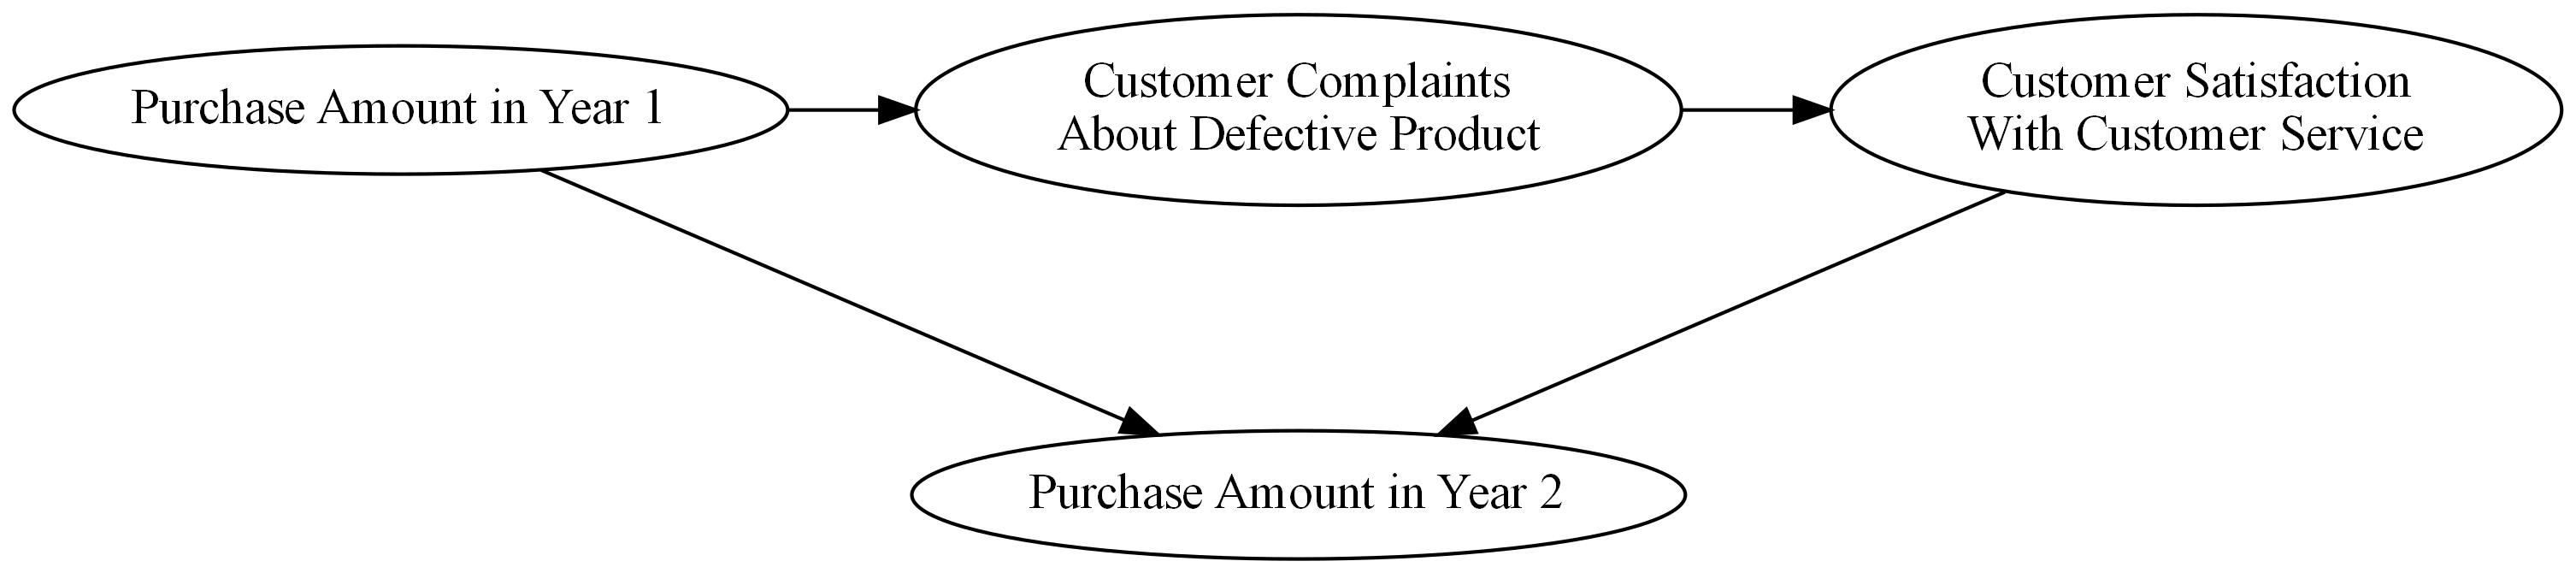

In [3]:
dot = Digraph("G", engine="neato", filename="ex.gv", format="png")

# Add nodes for x and y
dot.node('X', 'Purchase Amount in Year 1', pos='0,2!')
dot.node('T', 'Customer Complaints\nAbout Defective Product', pos='3.5,2!')
dot.node('P', 'Customer Satisfaction\nWith Customer Service', pos='7,2!')
dot.node('Y', 'Purchase Amount in Year 2', pos='3.5,0.5!')


# Add an edge linking x to y
dot.edge('X', 'T')
dot.edge('T', 'P')
dot.edge('P', 'Y')
dot.edge('X', 'Y')

dot.graph_attr['dpi'] = '300'
dot.render("complaints_dag", format="png", cleanup=True)

display(Image(filename="complaints_dag.png"))

In [4]:
# Set random seed for reproducibility
np.random.seed(1)

# Step 1: Simulate the data
n = 10000  # Number of samples

purchase_amount_yr1 = np.random.normal(200, 50, n)

# Treatment (T): random binary treatment assigned
customer_complaints = [np.random.binomial(1, 0.2 if x < 250 else 0.8) for x in purchase_amount_yr1] # T ~ Bernoulli(0.2) or T ~ Bernoulli(0.8)

# Customer satisfaction (P): depends on T and some noise
customer_satisfaction = 6.5 - 3 * np.array(customer_complaints) + np.random.normal(0, 1, n)  # Satisfaction depends on T with added noise
customer_satisfaction = np.round(np.clip(customer_satisfaction, 0, 10),0)  # Ensure satisfaction is within the range [1, 10]

# Post-treatment variable (P): depends on T and some noise
purchase_amount_yr2 = 0.1 * purchase_amount_yr1 + 40 * customer_satisfaction + np.random.normal(0, 50, n)

data = pd.DataFrame({'purchase_amount_yr1': purchase_amount_yr1, 'customer_complaints': customer_complaints, 'customer_satisfaction': customer_satisfaction, 'purchase_amount_yr2': purchase_amount_yr2})

In [5]:
data.head()

,purchase_amount_yr1,customer_complaints,customer_satisfaction,purchase_amount_yr2
0,281.217268,0,8.0,394.732000
1,169.412179,0,6.0,194.369060
2,173.591412,1,4.0,119.542770
3,146.351569,0,5.0,153.899658
4,243.270381,0,5.0,258.065493


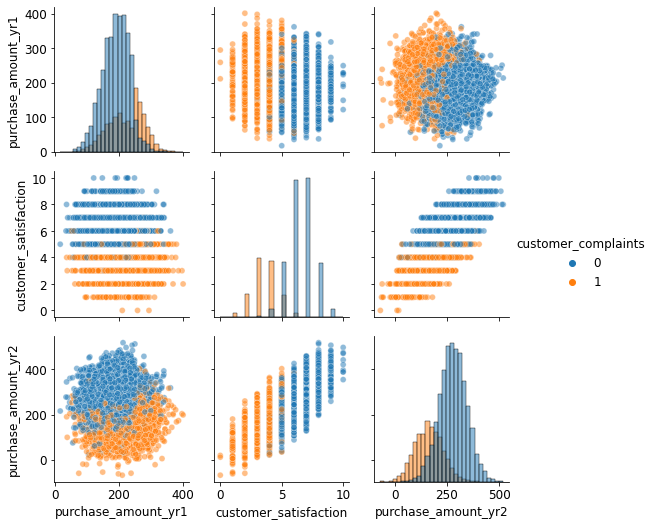

In [6]:
g = sns.PairGrid(data, hue='customer_complaints', diag_sharey=False)
g.map_diag(sns.histplot, kde=False, alpha=0.5, bins=30)
g.map_offdiag(sns.scatterplot, alpha=0.5)
g.add_legend()
plt.show()

#### Train test split

In [7]:
features = data[['purchase_amount_yr1','customer_complaints','customer_satisfaction']]
label = data['purchase_amount_yr2']

X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=42)

### Causal Inference

#### Causal inference model

In [8]:
causal_features = ['purchase_amount_yr1', 'customer_complaints']

causal_model = sm.OLS(endog=y_train, exog= sm.add_constant(X_train[causal_features])).fit()

print(causal_model.summary())

                             OLS Regression Results                            
Dep. Variable:     purchase_amount_yr2   R-squared:                       0.399
Model:                             OLS   Adj. R-squared:                  0.399
Method:                  Least Squares   F-statistic:                     2655.
Date:                 Tue, 08 Apr 2025   Prob (F-statistic):               0.00
Time:                         17:30:18   Log-Likelihood:                -44803.
No. Observations:                 8000   AIC:                         8.961e+04
Df Residuals:                     7997   BIC:                         8.963e+04
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 26

#### Predictive model

In [9]:
predictive_features = ['purchase_amount_yr1','customer_complaints','customer_satisfaction']

predictive_model = sm.OLS(endog=y_train, exog= sm.add_constant(X_train[predictive_features])).fit()

print(predictive_model.summary())

                             OLS Regression Results                            
Dep. Variable:     purchase_amount_yr2   R-squared:                       0.653
Model:                             OLS   Adj. R-squared:                  0.652
Method:                  Least Squares   F-statistic:                     5007.
Date:                 Tue, 08 Apr 2025   Prob (F-statistic):               0.00
Time:                         17:30:35   Log-Likelihood:                -42610.
No. Observations:                 8000   AIC:                         8.523e+04
Df Residuals:                     7996   BIC:                         8.526e+04
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const               

### Prediction

#### Causal inference model

In [10]:
# Assess the predictive performance of the causal model
y_pred = causal_model.predict(sm.add_constant(X_test[causal_features]))
causal_rmse = np.round(np.sqrt(mean_squared_error(y_test, y_pred)),2)
print(f'Causal model RMSE: {causal_rmse}')

Causal model RMSE: 66.12


#### Predictive model

In [11]:
# Assess the predictive performance of the predictive model
y_pred = predictive_model.predict(sm.add_constant(X_test[predictive_features]))
predictive_model_rmse = np.round(np.sqrt(mean_squared_error(y_test, y_pred)),2)
print(f'Predictive model RMSE: {predictive_model_rmse}')

Predictive model RMSE: 50.96


In [12]:
pct_increase_rmse = "{:.0%}".format((causal_rmse/predictive_model_rmse - 1))
print(f'The RMSE for the causal inference model is {pct_increase_rmse} higher than the RMSE of the Predictive Model.')

The RMSE for the causal inference model is 30% higher than the RMSE of the Predictive Model.


In [13]:
def generate_data():
    n = 10000  # Number of samples
    purchase_amount_yr1 = np.random.normal(200, 50, n)
    # Treatment (T): random binary treatment assigned
    customer_complaints = [np.random.binomial(1, 0.2 if x < 250 else 0.8) for x in purchase_amount_yr1] # T ~ Bernoulli(0.2) or T ~ Bernoulli(0.8)

    # Customer satisfaction (P): depends on T and some noise
    customer_satisfaction = 6.5 - 3 * np.array(customer_complaints) + np.random.normal(0, 1, n)  # Satisfaction depends on T with added noise
    customer_satisfaction = np.clip(customer_satisfaction, 0, 10)  # Ensure satisfaction is within the range [1, 10]

    # Post-treatment variable (P): depends on T and some noise
    purchase_amount_yr2 = 0.1 * purchase_amount_yr1 + 40 * customer_satisfaction + np.random.normal(0, 50, n)

    data = pd.DataFrame({'purchase_amount_yr1': purchase_amount_yr1, 'customer_complaints': customer_complaints, 'customer_satisfaction': customer_satisfaction, 'purchase_amount_yr2': purchase_amount_yr2})

    return data

In [14]:
def get_vif_data(X):
    vif_data = pd.DataFrame()
    vif_data['Feature'] = X.columns
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

In [15]:
def get_model_estimates(X_vars, X_train, X_test, y_train, y_test):
    
    X_train = X_train[X_vars]
    
    vif_data = get_vif_data(X_train)
    
    max_vif = vif_data.VIF.max()
    
    model = sm.OLS(endog=y_train, exog= sm.add_constant(X_train)).fit()
    
    effect_estimate = model.params['customer_complaints']
    
    pvalue = model.pvalues['customer_complaints']

    y_pred = model.predict(sm.add_constant(X_test[X_vars]))

    rmse = np.round(np.sqrt(mean_squared_error(y_test, y_pred)),2)

    output = {'effect_estimate': effect_estimate, 'max_vif': max_vif, 'pvalue': pvalue, 'rmse': rmse}

    return output


In [16]:

simulation_results = []

num_simulations = 1000

for i in range(num_simulations):

    data = generate_data()

    X_train, X_test, y_train, y_test = train_test_split(data[['purchase_amount_yr1','customer_complaints','customer_satisfaction']], data[['purchase_amount_yr2']], test_size=0.2, random_state=42)

    causal_estimates = get_model_estimates(['purchase_amount_yr1','customer_complaints'], X_train, X_test, y_train, y_test)

    causal_estimates['model'] = 'causal_inference'

    predictive_estimates = get_model_estimates(['purchase_amount_yr1','customer_complaints','customer_satisfaction'], X_train, X_test, y_train, y_test)

    predictive_estimates['model'] = 'prediction'

    df = pd.concat([pd.DataFrame([causal_estimates]),pd.DataFrame([predictive_estimates])],axis=0)

    df['simulation_run'] = i + 1

    simulation_results.append(df)

df_simulations = pd.concat(simulation_results,axis=0)


In [17]:
summary_stats_list = ['mean', 'std','min','max']

summary_stats = df_simulations.groupby('model').agg({
    'effect_estimate': summary_stats_list,
    'max_vif': summary_stats_list,
    'pvalue': summary_stats_list,
    'rmse': summary_stats_list
})

In [18]:
summary_stats['effect_estimate'].round(2).reset_index()

,model,mean,std,min,max
0,causal_inference,-119.97,1.7,-126.83,-115.02
1,prediction,-0.04,2.1,-6.43,6.07


In [19]:
summary_stats['pvalue'].round(3).reset_index()

,model,mean,std,min,max
0,causal_inference,0.000,0.000,0.000,0.000
1,prediction,0.498,0.285,0.002,0.999


In [20]:
summary_stats['rmse'].round(2).reset_index()

,model,mean,std,min,max
0,causal_inference,64.00,0.99,60.95,67.03
1,prediction,49.99,0.75,47.53,52.85


In [21]:
summary_stats['max_vif'].round(2).reset_index()

,model,mean,std,min,max
0,causal_inference,1.54,0.01,1.49,1.59
1,prediction,13.85,0.22,13.03,14.67


In [ ]:
from sklearn.linear_model import LinearRegression
from shap import LinearExplainer, plots

model = LinearRegression()
model.fit(X_train, y_train)

# Explain model predictions using SHAP
explainer = LinearExplainer(model, X_train)

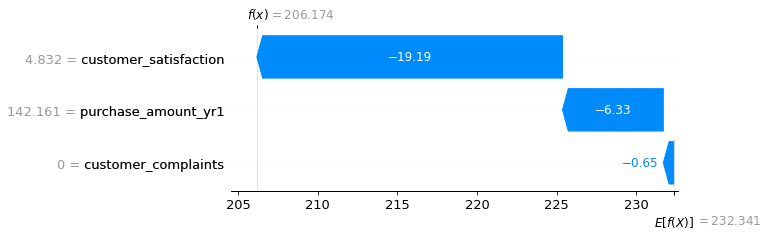

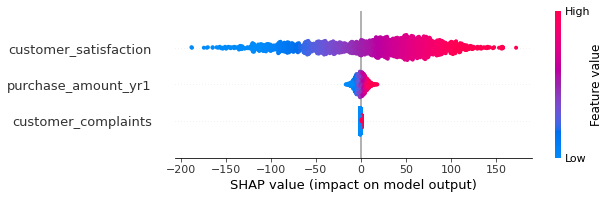

In [33]:
shap_values = explainer(X_test)  # explain test data

# Visualize
plots.waterfall(shap_values[0], max_display=10)  # explanation for first test sample
plots.beeswarm(shap_values)
